In [1]:
# first we need a bit of import boilerplate
import os
import pickle as pkl
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from pathlib import Path
import json
from IPython.display import display
from PIL import Image
from tqdm import tqdm
from neo import SpikeTrain
import quantities as pq
import warnings
from elephant.gpfa import GPFA
from sklearn.model_selection import cross_val_score

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys.ecephys_session import (
    EcephysSession, 
    removed_unused_stimulus_presentation_columns
)
from allensdk.brain_observatory.ecephys.visualization import plot_mean_waveforms, plot_spike_counts, raster_plot
from allensdk.brain_observatory.visualization import plot_running_speed

# tell pandas to show all columns when we display a DataFrame
pd.set_option("display.max_columns", None)

/var/folders/x1/kctky5lj58xftczlyf92pxcc0000gn/T/ipykernel_42304/2437169692.py:8: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
output_dir = os.path.expanduser("~/ecephys/data")
resources_dir = Path.cwd().parent / 'resources'
DOWNLOAD_LFP = False

# Obtain session data

In [3]:
# Example cache directory path, it determines where downloaded data will be stored
manifest_path = os.path.join(output_dir, "manifest.json")

cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

In [4]:
session_id = 756029989 # for example
session = cache.get_session_data(session_id)

/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.6.0-alpha is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


In [5]:
session.units.head()

/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.6.0-alpha is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached names

,waveform_PT_ratio,waveform_amplitude,amplitude_cutoff,cluster_id,cumulative_drift,d_prime,firing_rate,isi_violations,isolation_distance,L_ratio,local_index,max_drift,nn_hit_rate,nn_miss_rate,peak_channel_id,presence_ratio,waveform_recovery_slope,waveform_repolarization_slope,silhouette_score,snr,waveform_spread,waveform_velocity_above,waveform_velocity_below,waveform_duration,filtering,probe_channel_number,probe_horizontal_position,probe_id,probe_vertical_position,structure_acronym,ecephys_structure_id,ecephys_structure_acronym,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,left_right_ccf_coordinate,probe_description,location,probe_sampling_rate,probe_lfp_sampling_rate,probe_has_lfp_data
unit_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
951814884,0.522713,187.434780,0.042404,6,463.86,3.555518,9.492176,0.181638,46.750473,0.024771,5,45.64,0.727333,0.016202,850126382,0.99,-0.249885,0.673650,0.033776,3.342535,40.0,0.000000,0.000000,0.151089,AP band: 500 Hz high-pass; LFP band: 1000 Hz l...,4,43,760640083,60,APN,215.0,APN,8162.0,3487.0,6737.0,probeA,See electrode locations,29999.949611,1249.9979,True
951814876,0.652514,129.686505,0.097286,5,325.21,4.445414,39.100557,0.004799,85.178750,0.001785,4,40.68,1.000000,0.003756,850126382,0.99,-0.143762,0.518633,0.108908,2.589717,50.0,0.000000,0.000000,0.315913,AP band: 500 Hz high-pass; LFP band: 1000 Hz l...,4,43,760640083,60,APN,215.0,APN,8162.0,3487.0,6737.0,probeA,See electrode locations,29999.949611,1249.9979,True
951815032,0.484297,207.380940,0.015482,17,396.28,3.848256,28.383277,0.007099,89.608836,0.035654,15,40.01,0.986000,0.014673,850126398,0.99,-0.255492,0.766347,0.096715,3.811566,80.0,-0.206030,-0.686767,0.164824,AP band: 500 Hz high-pass; LFP band: 1000 Hz l...,12,43,760640083,140,APN,215.0,APN,8129.0,3419.0,6762.0,probeA,See electrode locations,29999.949611,1249.9979,True
951815275,0.600600,158.158650,0.063807,30,374.82,3.065938,5.709358,0.032317,48.114336,0.016783,27,33.32,0.883598,0.003683,850126416,0.99,-0.206676,0.628944,0.144249,2.918134,60.0,0.686767,0.000000,0.178559,AP band: 500 Hz high-pass; LFP band: 1000 Hz l...,21,11,760640083,220,APN,215.0,APN,8095.0,3349.0,6787.0,probeA,See electrode locations,29999.949611,1249.9979,True
951815314,0.459025,173.475705,0.072129,34,420.05,4.198612,23.902235,0.048075,76.916334,0.009666,31,42.80,0.968000,0.017600,850126420,0.99,-0.171503,0.740222,0.111106,3.360324,90.0,-0.068677,-0.274707,0.178559,AP band: 500 Hz high-pass; LFP band: 1000 Hz l...,23,27,760640083,240,APN,215.0,APN,8088.0,3333.0,6792.0,probeA,See electrode locations,29999.949611,1249.9979,True


# Get the right units data

In [6]:
print(f'{session.units.shape[0]} units total')
quality_units = session.units[
    (session.units['snr'] > 4)
    &(session.units['isi_violations'] < 0.2)]
print(f'{quality_units.shape[0]} are of acceptable quality')

684 units total
75 are of acceptable quality


In [7]:
session.stimulus_presentations.head()

/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.6.0-alpha is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


,stimulus_block,start_time,stop_time,frame,size,color,stimulus_name,phase,y_position,temporal_frequency,orientation,x_position,contrast,spatial_frequency,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,,,,,
0,null,24.429348,84.496188,null,null,null,spontaneous,null,null,null,null,null,null,null,60.066840,0
1,0.0,84.496188,84.729704,null,"[20.0, 20.0]",null,gabors,"[3644.93333333, 3644.93333333]",30.0,4.0,45.0,40.0,0.8,0.08,0.233516,1
2,0.0,84.729704,84.979900,null,"[20.0, 20.0]",null,gabors,"[3644.93333333, 3644.93333333]",10.0,4.0,45.0,-30.0,0.8,0.08,0.250196,2
3,0.0,84.979900,85.230095,null,"[20.0, 20.0]",null,gabors,"[3644.93333333, 3644.93333333]",-10.0,4.0,90.0,10.0,0.8,0.08,0.250196,3
4,0.0,85.230095,85.480291,null,"[20.0, 20.0]",null,gabors,"[3644.93333333, 3644.93333333]",40.0,4.0,90.0,30.0,0.8,0.08,0.250196,4


In [8]:
units = cache.get_units()
units.head()

,waveform_PT_ratio,waveform_amplitude,amplitude_cutoff,cumulative_drift,d_prime,waveform_duration,ecephys_channel_id,firing_rate,waveform_halfwidth,isi_violations,isolation_distance,L_ratio,max_drift,nn_hit_rate,nn_miss_rate,presence_ratio,waveform_recovery_slope,waveform_repolarization_slope,silhouette_score,snr,waveform_spread,waveform_velocity_above,waveform_velocity_below,ecephys_probe_id,local_index,probe_horizontal_position,probe_vertical_position,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,left_right_ccf_coordinate,ecephys_structure_id,ecephys_structure_acronym,ecephys_session_id,lfp_sampling_rate,name,phase,sampling_rate,has_lfp_data,date_of_acquisition,published_at,specimen_id,session_type,age_in_days,sex,genotype
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
915956282,0.611816,164.878740,0.072728,309.71,3.910873,0.535678,850229419,6.519432,0.164824,0.104910,30.546900,0.013865,27.10,0.898126,0.001599,0.99,-0.087545,0.480915,0.102369,1.911839,30.0,0.000000,NaN,733744647,3,27,40,NaN,NaN,NaN,8.0,grey,732592105,1249.996475,probeB,3a,29999.915391,True,2019-01-09T00:26:20Z,2019-10-03T00:00:00Z,717038288,brain_observatory_1.1,100.0,M,wt/wt
915956340,0.439372,247.254345,0.000881,160.24,5.519024,0.563149,850229419,9.660554,0.206030,0.006825,59.613182,0.000410,7.79,0.987654,0.000903,0.99,-0.104196,0.704522,0.197458,3.357908,30.0,0.000000,NaN,733744647,3,27,40,NaN,NaN,NaN,8.0,grey,732592105,1249.996475,probeB,3a,29999.915391,True,2019-01-09T00:26:20Z,2019-10-03T00:00:00Z,717038288,brain_observatory_1.1,100.0,M,wt/wt
915956345,0.500520,251.275830,0.001703,129.36,3.559911,0.521943,850229419,12.698430,0.192295,0.044936,47.805714,0.008281,11.56,0.930000,0.004956,0.99,-0.153127,0.781296,0.138827,3.362198,30.0,0.343384,NaN,733744647,3,27,40,NaN,NaN,NaN,8.0,grey,732592105,1249.996475,probeB,3a,29999.915391,True,2019-01-09T00:26:20Z,2019-10-03T00:00:00Z,717038288,brain_observatory_1.1,100.0,M,wt/wt
915956349,0.424620,177.115380,0.096378,169.29,2.973959,0.508208,850229419,16.192413,0.192295,0.120715,54.635515,0.010406,14.87,0.874667,0.021636,0.99,-0.086022,0.553393,0.136901,2.684636,40.0,0.206030,NaN,733744647,3,27,40,NaN,NaN,NaN,8.0,grey,732592105,1249.996475,probeB,3a,29999.915391,True,2019-01-09T00:26:20Z,2019-10-03T00:00:00Z,717038288,brain_observatory_1.1,100.0,M,wt/wt
915956356,0.512847,214.954545,0.054706,263.01,2.936851,0.549414,850229419,2.193113,0.233501,0.430427,18.136302,0.061345,18.37,0.637363,0.000673,0.99,-0.106051,0.632977,0.108867,2.605408,60.0,-0.451304,NaN,733744647,3,27,40,NaN,NaN,NaN,8.0,grey,732592105,1249.996475,probeB,3a,29999.915391,True,2019-01-09T00:26:20Z,2019-10-03T00:00:00Z,717038288,brain_observatory_1.1,100.0,M,wt/wt


In [9]:
# There are quite a few of these
print(units.shape[0])

40010


In [10]:
session.stimulus_names # just the unique values from the 'stimulus_name' column

['spontaneous',
 'gabors',
 'flashes',
 'drifting_gratings',
 'natural_movie_three',
 'natural_movie_one',
 'static_gratings',
 'natural_scenes']

In [11]:
session.get_stimulus_epochs()

,start_time,stop_time,duration,stimulus_name,stimulus_block
0,24.429348,84.496188,60.066840,spontaneous,null
1,84.496188,996.491813,911.995625,gabors,0.0
2,996.491813,1285.483398,288.991585,spontaneous,null
3,1285.483398,1583.982946,298.499548,flashes,1.0
4,1583.982946,1585.734418,1.751472,spontaneous,null
5,1585.734418,2185.235561,599.501143,drifting_gratings,2.0
6,2185.235561,2216.261498,31.025937,spontaneous,null
7,2216.261498,2816.763498,600.502000,natural_movie_three,3.0
8,2816.763498,2846.788598,30.025100,spontaneous,null
9,2846.788598,3147.039578,300.250980,natural_movie_one,4.0


In [12]:
session.get_stimulus_table(['drifting_gratings']).head()


,stimulus_block,start_time,stop_time,size,stimulus_name,phase,temporal_frequency,orientation,contrast,spatial_frequency,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,
3798,2.0,1585.734418,1587.736098,"[250.0, 250.0]",drifting_gratings,"[42471.86666667, 42471.86666667]",2.0,180.0,0.8,0.04,2.00168,246
3799,2.0,1588.736891,1590.738571,"[250.0, 250.0]",drifting_gratings,"[42471.86666667, 42471.86666667]",2.0,135.0,0.8,0.04,2.00168,247
3800,2.0,1591.739398,1593.741078,"[250.0, 250.0]",drifting_gratings,"[42471.86666667, 42471.86666667]",2.0,180.0,0.8,0.04,2.00168,246
3801,2.0,1594.741921,1596.743591,"[250.0, 250.0]",drifting_gratings,"[42471.86666667, 42471.86666667]",2.0,270.0,0.8,0.04,2.00167,248
3802,2.0,1597.744458,1599.746088,"[250.0, 250.0]",drifting_gratings,"[42471.86666667, 42471.86666667]",4.0,135.0,0.8,0.04,2.00163,249


In [13]:
for key, values in session.get_stimulus_parameter_values().items():
    print(f'{key}: {values}')

frame: [0.0 1.0 2.0 ... 3598.0 3599.0 -1.0]
size: ['[20.0, 20.0]' '[300.0, 300.0]' '[250.0, 250.0]' '[1920.0, 1080.0]']
color: [-1.0 1.0]
phase: ['[3644.93333333, 3644.93333333]' '[0.0, 0.0]'
 '[42471.86666667, 42471.86666667]' '0.0' '0.25' '0.5' '0.75']
y_position: [30.0 10.0 -10.0 40.0 -40.0 -20.0 0.0 20.0 -30.0]
temporal_frequency: [4.0 2.0 15.0 1.0 8.0]
orientation: [45.0 90.0 0.0 180.0 135.0 270.0 315.0 225.0 30.0 150.0 120.0 60.0]
x_position: [40.0 -30.0 10.0 30.0 0.0 -40.0 -20.0 -10.0 20.0]
contrast: [0.8 1.0]
spatial_frequency: ['0.08' '[0.0, 0.0]' '0.04' 0.08 0.04 0.32 0.02 0.16]


In [14]:
 # grab an arbitrary (though high-snr!) unit (we made units_with_high_snr above)
quality_unit_ids = quality_units.index.values
unit_id = quality_unit_ids[0]

print(f"{len(session.spike_times[unit_id])} spikes were detected for unit {unit_id} at times:")
session.spike_times[unit_id]

236169 spikes were detected for unit 951816951 at times:


array([3.81328401e+00, 4.20301799e+00, 4.30151816e+00, ...,
       9.96615988e+03, 9.96617945e+03, 9.96619655e+03])

# Store unit spike train data, get trajectories

In [15]:
from neo.core import SpikeTrain
import quantities as pq
from tqdm import tqdm


In [16]:

# get spike times from the drifting gratings presentations 
drifting_gratings_presentation_ids = session.stimulus_presentations.loc[
    (session.stimulus_presentations['stimulus_name'] == 'drifting_gratings')
].index.values

times = session.presentationwise_spike_times(
    stimulus_presentation_ids=drifting_gratings_presentation_ids,
    unit_ids=quality_unit_ids
)

# sort the spikes in stimulus_presentation_id, units, and time_since_stimulus_onset.
# In other words, we sort individual presentation data by unit chronologically
sorted_spikes=times.sort_values(by=['stimulus_presentation_id','unit_id','time_since_stimulus_presentation_onset'])

# get all stimulus presentation ids
stims = sorted_spikes['stimulus_presentation_id'].unique()

In [17]:
speeds = session.running_speed
speeds['midpoint'] = speeds['start_time'].values+(speeds['end_time'].values - speeds['start_time'].values)/2

In [18]:
times['speed'] = times.index.to_series().map(lambda a: np.abs(speeds['velocity'].values[np.argmin(np.abs(speeds['midpoint'].values-a))]))

In [19]:

spike_train_trials = []

N_trials = 100

# get spike trains for the given ids
for stim in tqdm(stims[:N_trials],desc=f'Getting spike trains for {N_trials} drifting_grating stimulus trials'):
    spike_trains = []

    # Get the start and stop time for the spike train
    t_start = session.get_stimulus_table().loc[stim]['start_time']
    t_stop = session.get_stimulus_table().loc[stim]['stop_time']

    print(stim, t_start, t_stop)

    # Get the spike buckets
    # We will use these to get the running speeds
    buckets = np.arange(np.round(t_start,2),np.round(t_stop,2),.02)
    if buckets.shape[0] == 101:
        buckets = buckets[1:]
    try:
        assert buckets.shape[0] == 100
    except AssertionError:
        print(f'Time buckets for stimulus is too large / small! Stim: {stim}')

    for unit_id in tqdm(sorted_spikes['unit_id'].unique(), 
                        desc = 'Getting individual spike trains for each unit in trial',
                        leave = False):
        # Get spike train for the unit during the presented stimulus
        df_spike_train = sorted_spikes[
            (sorted_spikes['stimulus_presentation_id']==stim)
            &(sorted_spikes['unit_id']==unit_id)]
        # Store spike train in neo.SpikeTrain instance, append to the spike trains for the trial
        spike_trains.append(SpikeTrain(times=df_spike_train.index.to_numpy(),
                                       t_start=t_start,
                                       t_stop=t_stop,
                                       units=pq.s))
    # Append trial spike trains to the full list of trials
    spike_train_trials.append((spike_trains,buckets))



Getting spike trains for 100 drifting_grating stimulus trials:   0%|          | 0/100 [00:00<?, ?it/s]

3798 1585.7344179863614 1587.736097986361


Getting spike trains for 100 drifting_grating stimulus trials:   1%|          | 1/100 [00:00<01:24,  1.17it/s]

3799 1588.7368909550662 1590.7385709550658


Getting spike trains for 100 drifting_grating stimulus trials:   2%|▏         | 2/100 [00:01<01:20,  1.22it/s]

3800 1591.7393979863614 1593.7410779863615


Getting spike trains for 100 drifting_grating stimulus trials:   3%|▎         | 3/100 [00:02<01:16,  1.26it/s]

3801 1594.7419209550662 1596.7435909550659


Getting spike trains for 100 drifting_grating stimulus trials:   4%|▍         | 4/100 [00:03<01:14,  1.28it/s]

3802 1597.744457986361 1599.746087986361


Getting spike trains for 100 drifting_grating stimulus trials:   5%|▌         | 5/100 [00:03<01:12,  1.30it/s]

3803 1600.746920955066 1602.7486009550662


Getting spike trains for 100 drifting_grating stimulus trials:   6%|▌         | 6/100 [00:04<01:12,  1.31it/s]

3804 1603.7494579863614 1605.7511479863615


Getting spike trains for 100 drifting_grating stimulus trials:   7%|▋         | 7/100 [00:05<01:10,  1.32it/s]

3805 1606.751960955066 1608.7536309550662


Getting spike trains for 100 drifting_grating stimulus trials:   8%|▊         | 8/100 [00:06<01:09,  1.32it/s]

3806 1609.7544979863615 1611.756167986361


Getting spike trains for 100 drifting_grating stimulus trials:   9%|▉         | 9/100 [00:06<01:08,  1.33it/s]

3807 1612.7569709550662 1614.7586409550659


Getting spike trains for 100 drifting_grating stimulus trials:  10%|█         | 10/100 [00:07<01:07,  1.33it/s]

3808 1615.759517986361 1617.7611979863614


Getting spike trains for 100 drifting_grating stimulus trials:  11%|█         | 11/100 [00:08<01:07,  1.33it/s]

3809 1618.7619909550658 1620.763670955066


Getting spike trains for 100 drifting_grating stimulus trials:  12%|█▏        | 12/100 [00:09<01:06,  1.33it/s]

3810 1621.7645079863614 1623.7662179863614


Getting spike trains for 100 drifting_grating stimulus trials:  13%|█▎        | 13/100 [00:09<01:05,  1.34it/s]

3811 1624.7670309550658 1626.7686909550662


Getting spike trains for 100 drifting_grating stimulus trials:  14%|█▍        | 14/100 [00:10<01:04,  1.34it/s]

3812 1627.7695379863615 1629.771217986361


Getting spike trains for 100 drifting_grating stimulus trials:  15%|█▌        | 15/100 [00:11<01:03,  1.34it/s]

3813 1630.7720309550662 1632.7737109550662


Getting spike trains for 100 drifting_grating stimulus trials:  16%|█▌        | 16/100 [00:12<01:02,  1.35it/s]

3814 1633.774547986361 1635.776247986361


Getting spike trains for 100 drifting_grating stimulus trials:  17%|█▋        | 17/100 [00:12<01:02,  1.34it/s]

3815 1636.7770509550662 1638.7787209550659


Getting spike trains for 100 drifting_grating stimulus trials:  18%|█▊        | 18/100 [00:13<01:01,  1.34it/s]

3816 1639.7795479863614 1641.7812679863614


Getting spike trains for 100 drifting_grating stimulus trials:  19%|█▉        | 19/100 [00:14<01:00,  1.34it/s]

3817 1642.7820609550658 1644.783750955066


Getting spike trains for 100 drifting_grating stimulus trials:  20%|██        | 20/100 [00:15<00:59,  1.34it/s]

3818 1645.784627986361 1647.7862679863613


Getting spike trains for 100 drifting_grating stimulus trials:  21%|██        | 21/100 [00:15<00:59,  1.33it/s]

3819 1648.7871009550659 1650.7887709550662


Getting spike trains for 100 drifting_grating stimulus trials:  22%|██▏       | 22/100 [00:16<00:59,  1.32it/s]

3820 1651.7896079863615 1653.791297986361


Getting spike trains for 100 drifting_grating stimulus trials:  23%|██▎       | 23/100 [00:17<01:05,  1.17it/s]

3821 1654.7921109550662 1656.793790955066


Getting spike trains for 100 drifting_grating stimulus trials:  24%|██▍       | 24/100 [00:18<01:03,  1.21it/s]

3822 1657.794637986361 1659.7963279863613


Getting spike trains for 100 drifting_grating stimulus trials:  25%|██▌       | 25/100 [00:19<01:00,  1.23it/s]

3823 1660.7971409550662 1662.7988109550658


Getting spike trains for 100 drifting_grating stimulus trials:  26%|██▌       | 26/100 [00:20<00:59,  1.25it/s]

3824 1663.7996879863613 1665.8013379863614


Getting spike trains for 100 drifting_grating stimulus trials:  27%|██▋       | 27/100 [00:20<00:56,  1.28it/s]

3825 1666.8021509550658 1668.803830955066


Getting spike trains for 100 drifting_grating stimulus trials:  28%|██▊       | 28/100 [00:21<00:55,  1.29it/s]

3826 1669.8046479863615 1671.806347986361


Getting spike trains for 100 drifting_grating stimulus trials:  29%|██▉       | 29/100 [00:22<00:54,  1.29it/s]

3827 1672.8071709550659 1674.8088509550662


Getting spike trains for 100 drifting_grating stimulus trials:  30%|███       | 30/100 [00:23<00:53,  1.31it/s]

3828 1675.809677986361 1677.8113579863614


Getting spike trains for 100 drifting_grating stimulus trials:  31%|███       | 31/100 [00:23<00:52,  1.33it/s]

3829 1678.812200955066 1680.8138609550658


Getting spike trains for 100 drifting_grating stimulus trials:  32%|███▏      | 32/100 [00:24<00:51,  1.33it/s]

3830 1681.8147379863615 1683.8163779863614


Getting spike trains for 100 drifting_grating stimulus trials:  33%|███▎      | 33/100 [00:25<00:50,  1.32it/s]

3831 1684.8172209550662 1686.8188909550659


Getting spike trains for 100 drifting_grating stimulus trials:  34%|███▍      | 34/100 [00:26<00:49,  1.33it/s]

3832 1687.8197779863615 1689.821387986361


Getting spike trains for 100 drifting_grating stimulus trials:  35%|███▌      | 35/100 [00:26<00:48,  1.33it/s]

3833 1690.8222309550658 1692.823910955066


Getting spike trains for 100 drifting_grating stimulus trials:  36%|███▌      | 36/100 [00:27<00:48,  1.32it/s]

3834 1693.8247479863614 1695.826417986361


Getting spike trains for 100 drifting_grating stimulus trials:  37%|███▋      | 37/100 [00:28<00:48,  1.31it/s]

3835 1696.827250955066 1698.8289309550662


Getting spike trains for 100 drifting_grating stimulus trials:  38%|███▊      | 38/100 [00:29<00:47,  1.30it/s]

3836 1699.8297679863613 1701.8314879863615


Getting spike trains for 100 drifting_grating stimulus trials:  39%|███▉      | 39/100 [00:29<00:48,  1.26it/s]

3837 1702.8322809550662 1704.833950955066


Getting spike trains for 100 drifting_grating stimulus trials:  40%|████      | 40/100 [00:30<00:47,  1.27it/s]

3838 1705.834807986361 1707.8364679863614


Getting spike trains for 100 drifting_grating stimulus trials:  41%|████      | 41/100 [00:31<00:45,  1.28it/s]

3839 1708.8373009550662 1710.8389709550659


Getting spike trains for 100 drifting_grating stimulus trials:  42%|████▏     | 42/100 [00:32<00:45,  1.29it/s]

3840 1711.8398079863614 1713.8414779863615


Getting spike trains for 100 drifting_grating stimulus trials:  43%|████▎     | 43/100 [00:33<00:44,  1.30it/s]

3841 1714.8423209550658 1716.843990955066


Getting spike trains for 100 drifting_grating stimulus trials:  44%|████▍     | 44/100 [00:33<00:42,  1.30it/s]

3842 1717.8448179863615 1719.8464879863614


Getting spike trains for 100 drifting_grating stimulus trials:  45%|████▌     | 45/100 [00:34<00:41,  1.31it/s]

3843 1720.847330955066 1722.8490009550662


Getting spike trains for 100 drifting_grating stimulus trials:  46%|████▌     | 46/100 [00:35<00:40,  1.32it/s]

3844 1723.8498579863615 1725.851547986361


Getting spike trains for 100 drifting_grating stimulus trials:  47%|████▋     | 47/100 [00:36<00:40,  1.32it/s]

3845 1726.8523609550662 1728.8540209550658


Getting spike trains for 100 drifting_grating stimulus trials:  48%|████▊     | 48/100 [00:36<00:39,  1.32it/s]

3846 1729.854877986361 1731.8565279863615


Getting spike trains for 100 drifting_grating stimulus trials:  49%|████▉     | 49/100 [00:37<00:38,  1.33it/s]

3847 1732.8573809550662 1734.859040955066


Getting spike trains for 100 drifting_grating stimulus trials:  50%|█████     | 50/100 [00:38<00:37,  1.34it/s]

3848 1735.8598879863614 1737.861547986361


Getting spike trains for 100 drifting_grating stimulus trials:  51%|█████     | 51/100 [00:39<00:36,  1.34it/s]

3849 1738.8623909550658 1740.8640709550662


Getting spike trains for 100 drifting_grating stimulus trials:  52%|█████▏    | 52/100 [00:39<00:35,  1.35it/s]

3850 1741.8648979863615 1743.8665579863614


Getting spike trains for 100 drifting_grating stimulus trials:  53%|█████▎    | 53/100 [00:40<00:34,  1.35it/s]

3851 1744.8674309550659 1746.8690909550662


Getting spike trains for 100 drifting_grating stimulus trials:  54%|█████▍    | 54/100 [00:41<00:34,  1.35it/s]

3852 1747.869917986361 1749.8716079863614


Getting spike trains for 100 drifting_grating stimulus trials:  55%|█████▌    | 55/100 [00:41<00:33,  1.35it/s]

3853 1750.8724409550662 1752.8741109550658


Getting spike trains for 100 drifting_grating stimulus trials:  56%|█████▌    | 56/100 [00:42<00:32,  1.35it/s]

3854 1753.8749279863614 1755.8766579863614


Getting spike trains for 100 drifting_grating stimulus trials:  57%|█████▋    | 57/100 [00:43<00:32,  1.34it/s]

3855 1756.8774409550658 1758.8791309550659


Getting spike trains for 100 drifting_grating stimulus trials:  58%|█████▊    | 58/100 [00:44<00:31,  1.34it/s]

3856 1759.8799579863614 1761.8816479863615


Getting spike trains for 100 drifting_grating stimulus trials:  59%|█████▉    | 59/100 [00:44<00:30,  1.34it/s]

3857 1762.8824709550659 1764.8841509550662


Getting spike trains for 100 drifting_grating stimulus trials:  60%|██████    | 60/100 [00:45<00:29,  1.34it/s]

3858 1765.8849979863614 1767.886677986361


Getting spike trains for 100 drifting_grating stimulus trials:  61%|██████    | 61/100 [00:46<00:29,  1.34it/s]

3859 1768.887490955066 1770.8891809550662


Getting spike trains for 100 drifting_grating stimulus trials:  62%|██████▏   | 62/100 [00:47<00:28,  1.34it/s]

3860 1771.890007986361 1773.8916879863614


Getting spike trains for 100 drifting_grating stimulus trials:  63%|██████▎   | 63/100 [00:47<00:27,  1.35it/s]

3861 1774.8925109550662 1776.8941909550658


Getting spike trains for 100 drifting_grating stimulus trials:  64%|██████▍   | 64/100 [00:48<00:26,  1.35it/s]

3862 1777.894957986361 1779.8966879863615


Getting spike trains for 100 drifting_grating stimulus trials:  65%|██████▌   | 65/100 [00:49<00:25,  1.35it/s]

3863 1780.897530955066 1782.8992109550659


Getting spike trains for 100 drifting_grating stimulus trials:  66%|██████▌   | 66/100 [00:50<00:25,  1.34it/s]

3864 1783.9000479863614 1785.9017279863615


Getting spike trains for 100 drifting_grating stimulus trials:  67%|██████▋   | 67/100 [00:50<00:24,  1.34it/s]

3865 1786.9025609550658 1788.9042309550662


Getting spike trains for 100 drifting_grating stimulus trials:  68%|██████▊   | 68/100 [00:51<00:23,  1.35it/s]

3866 1789.9050679863615 1791.9067279863614


Getting spike trains for 100 drifting_grating stimulus trials:  69%|██████▉   | 69/100 [00:52<00:23,  1.34it/s]

3867 1792.907580955066 1794.9092609550662


Getting spike trains for 100 drifting_grating stimulus trials:  70%|███████   | 70/100 [00:53<00:22,  1.34it/s]

3868 1795.9100979863613 1797.9117779863614


Getting spike trains for 100 drifting_grating stimulus trials:  71%|███████   | 71/100 [00:53<00:21,  1.33it/s]

3869 1798.9126009550662 1800.9142609550659


Getting spike trains for 100 drifting_grating stimulus trials:  72%|███████▏  | 72/100 [00:54<00:21,  1.32it/s]

3870 1801.915117986361 1803.9167779863608


Getting spike trains for 100 drifting_grating stimulus trials:  73%|███████▎  | 73/100 [00:55<00:20,  1.32it/s]

3871 1804.917620955066 1806.9193009550659


Getting spike trains for 100 drifting_grating stimulus trials:  74%|███████▍  | 74/100 [00:56<00:19,  1.33it/s]

3872 1807.9201279863607 1809.921787986361


Getting spike trains for 100 drifting_grating stimulus trials:  75%|███████▌  | 75/100 [00:56<00:18,  1.33it/s]

3873 1810.9226509550658 1812.9243209550666


Getting spike trains for 100 drifting_grating stimulus trials:  76%|███████▌  | 76/100 [00:57<00:18,  1.29it/s]

3874 1813.9251679863607 1815.9268179863607


Getting spike trains for 100 drifting_grating stimulus trials:  77%|███████▋  | 77/100 [00:58<00:18,  1.27it/s]

3875 1816.9276709550659 1818.9293409550664


Getting spike trains for 100 drifting_grating stimulus trials:  78%|███████▊  | 78/100 [00:59<00:17,  1.27it/s]

3876 1819.9301479863607 1821.9318379863607


Getting spike trains for 100 drifting_grating stimulus trials:  79%|███████▉  | 79/100 [01:00<00:16,  1.26it/s]

3877 1822.9326809550664 1824.9343509550658


Getting spike trains for 100 drifting_grating stimulus trials:  80%|████████  | 80/100 [01:00<00:15,  1.27it/s]

3878 1825.9351679863607 1827.9368579863608


Getting spike trains for 100 drifting_grating stimulus trials:  81%|████████  | 81/100 [01:01<00:14,  1.28it/s]

3879 1828.9376909550658 1830.939370955066


Getting spike trains for 100 drifting_grating stimulus trials:  82%|████████▏ | 82/100 [01:02<00:13,  1.30it/s]

3880 1831.9401979863608 1833.941867986361


Getting spike trains for 100 drifting_grating stimulus trials:  83%|████████▎ | 83/100 [01:03<00:12,  1.31it/s]

3881 1834.9427109550659 1836.9443909550666


Getting spike trains for 100 drifting_grating stimulus trials:  84%|████████▍ | 84/100 [01:03<00:12,  1.32it/s]

3882 1837.9452479863608 1839.9468979863607


Getting spike trains for 100 drifting_grating stimulus trials:  85%|████████▌ | 85/100 [01:04<00:11,  1.32it/s]

3883 1840.9477509550659 1842.9494309550664


Getting spike trains for 100 drifting_grating stimulus trials:  86%|████████▌ | 86/100 [01:05<00:10,  1.31it/s]

3884 1843.950247986361 1845.951947986361


Getting spike trains for 100 drifting_grating stimulus trials:  87%|████████▋ | 87/100 [01:06<00:09,  1.31it/s]

3885 1846.9527609550664 1848.9544409550658


Getting spike trains for 100 drifting_grating stimulus trials:  88%|████████▊ | 88/100 [01:06<00:09,  1.31it/s]

3886 1849.955287986361 1851.956917986361


Getting spike trains for 100 drifting_grating stimulus trials:  89%|████████▉ | 89/100 [01:07<00:08,  1.31it/s]

3887 1852.957780955066 1854.9594609550659


Getting spike trains for 100 drifting_grating stimulus trials:  90%|█████████ | 90/100 [01:08<00:07,  1.31it/s]

3888 1855.960257986361 1857.961967986361


Getting spike trains for 100 drifting_grating stimulus trials:  91%|█████████ | 91/100 [01:09<00:06,  1.31it/s]

3889 1858.9628009550659 1860.9644709550664


Getting spike trains for 100 drifting_grating stimulus trials:  92%|█████████▏| 92/100 [01:10<00:06,  1.30it/s]

3890 1861.965277986361 1863.966987986361


Getting spike trains for 100 drifting_grating stimulus trials:  93%|█████████▎| 93/100 [01:10<00:05,  1.31it/s]

3891 1864.9678109550666 1866.969490955066


Getting spike trains for 100 drifting_grating stimulus trials:  94%|█████████▍| 94/100 [01:11<00:04,  1.32it/s]

3892 1867.9703179863607 1869.9719779863615


Getting spike trains for 100 drifting_grating stimulus trials:  95%|█████████▌| 95/100 [01:12<00:03,  1.29it/s]

3893 1870.9728409550664 1872.9745109550659


Getting spike trains for 100 drifting_grating stimulus trials:  96%|█████████▌| 96/100 [01:13<00:03,  1.23it/s]

3894 1873.9753579863607 1875.9770479863607


Getting spike trains for 100 drifting_grating stimulus trials:  97%|█████████▋| 97/100 [01:14<00:02,  1.24it/s]

3895 1876.9778709550665 1878.979530955066


Getting spike trains for 100 drifting_grating stimulus trials:  98%|█████████▊| 98/100 [01:14<00:01,  1.26it/s]

3896 1879.9803879863607 1881.982037986361


Getting spike trains for 100 drifting_grating stimulus trials:  99%|█████████▉| 99/100 [01:15<00:00,  1.28it/s]

3897 1882.9828809550659 1884.9845609550666


Getting spike trains for 100 drifting_grating stimulus trials: 100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


In [20]:
first_drifting_grating_presentation_id = times['stimulus_presentation_id'].unique()[0]
plot_times = times[times['stimulus_presentation_id'] == first_drifting_grating_presentation_id]
plot_times


,stimulus_presentation_id,unit_id,time_since_stimulus_presentation_onset,speed
spike_time,,,,
1585.734841,3798,951817927,0.000423,1.591327
1585.736862,3798,951812742,0.002444,1.591327
1585.738591,3798,951805427,0.004173,1.591327
1585.738941,3798,951816951,0.004523,1.591327
1585.738995,3798,951820510,0.004577,1.591327
...,...,...,...,...
1587.728678,3798,951817324,1.994260,13.832394
1587.729126,3798,951804520,1.994708,13.832394
1587.731144,3798,951817927,1.996726,13.832394


(54,)


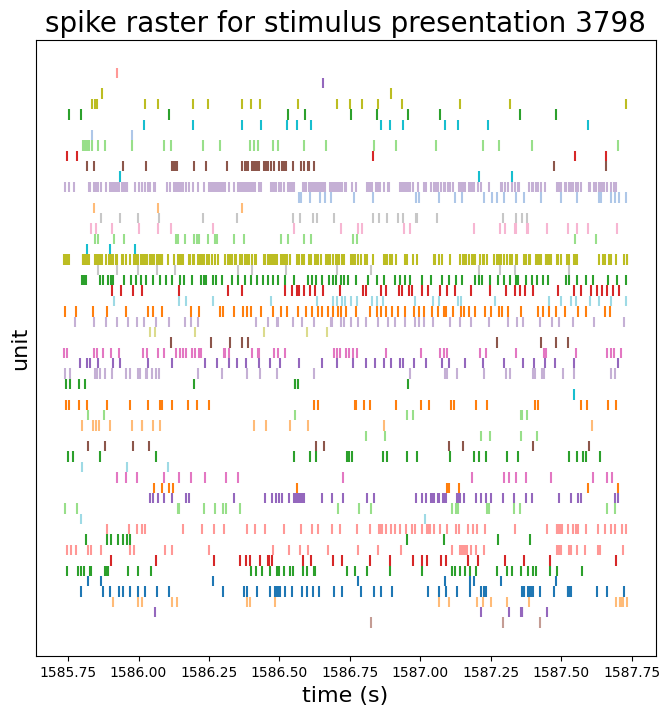

<Figure size 640x480 with 0 Axes>

In [22]:
print(plot_times['unit_id'].unique().shape)
fig = raster_plot(plot_times, title=f'spike raster for stimulus presentation {first_drifting_grating_presentation_id}')
plt.show()
plt.savefig(f'./plots/raster_{first_drifting_grating_presentation_id}.png')

In [23]:
times.to_csv('../data/processed/quality_spike_times_drifting_gratings.csv')

In [24]:
with open('../data/processed/spike_train_trials_drifting_gratings.pkl','wb') as f:
    pkl.dump(spike_train_trials,f)

# GPFA on Spike Trains

In [25]:
with open('../data/processed/spike_train_trials_drifting_gratings.pkl','rb') as f:
    spike_train_trials = pkl.load(f)

In [26]:
spike_train_trials

[([SpikeTrain containing 3 spikes; units s; datatype float64 
   time: 1585.7344179863614 s to 1587.736097986361 s,
   SpikeTrain containing 7 spikes; units s; datatype float64 
   time: 1585.7344179863614 s to 1587.736097986361 s,
   SpikeTrain containing 21 spikes; units s; datatype float64 
   time: 1585.7344179863614 s to 1587.736097986361 s,
   SpikeTrain containing 60 spikes; units s; datatype float64 
   time: 1585.7344179863614 s to 1587.736097986361 s,
   SpikeTrain containing 9 spikes; units s; datatype float64 
   time: 1585.7344179863614 s to 1587.736097986361 s,
   SpikeTrain containing 46 spikes; units s; datatype float64 
   time: 1585.7344179863614 s to 1587.736097986361 s,
   SpikeTrain containing 27 spikes; units s; datatype float64 
   time: 1585.7344179863614 s to 1587.736097986361 s,
   SpikeTrain containing 39 spikes; units s; datatype float64 
   time: 1585.7344179863614 s to 1587.736097986361 s,
   SpikeTrain containing 11 spikes; units s; datatype float64 
   t

In [27]:
with warnings.catch_warnings(action='ignore'):
    # We will select best x_dim based on log likelihood
    x_dims = range(1,20)
    log_likelihoods = []
    for x_dim in tqdm(x_dims, desc='Testing best dimensions n for GPFA'):
        gpfa_cv = GPFA(bin_size=20*pq.ms, x_dim=x_dim)
        # estimate the log-likelihood for the given dimensionality as the mean of the log-likelihoods from 3 cross-vailidation folds
        cv_log_likelihoods = cross_val_score(gpfa_cv, [trial for (trial,_) in spike_train_trials], cv=3, n_jobs=3, verbose=True)
        log_likelihoods.append(np.mean(cv_log_likelihoods))

Testing best dimensions n for GPFA:   0%|          | 0/19 [00:00<?, ?it/s][Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 3 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 3 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  wa

Initializing parameters using factor analysis...
Initializing parameters using factor analysis...
Initializing parameters using factor analysis...

Fitting GPFA model...

Fitting GPFA model...

Fitting GPFA model...
Fitting has converged after 480 EM iterations.)
Fitting has converged after 475 EM iterations.)


/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 3 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:113

Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...


/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 3 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 4 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:113

Initializing parameters using factor analysis...

Fitting GPFA model...


/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 4 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "


Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...


/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 3 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 4 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:113

Initializing parameters using factor analysis...

Fitting GPFA model...


/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 4 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "


Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...


/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 3 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 4 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:113

Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...


/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 3 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 4 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:113

Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...


/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 4 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "


Initializing parameters using factor analysis...

Fitting GPFA model...


/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 3 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 4 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:113

Initializing parameters using factor analysis...

Fitting GPFA model...


/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 4 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "


Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...


/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 3 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 4 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:113

Initializing parameters using factor analysis...

Fitting GPFA model...


/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 4 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "


Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...


/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 3 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 4 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:113

Initializing parameters using factor analysis...

Fitting GPFA model...


/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 4 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "


Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...


/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 3 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 4 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:113

Initializing parameters using factor analysis...

Fitting GPFA model...


/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 4 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "


Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...


/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 3 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 4 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:113

Initializing parameters using factor analysis...

Fitting GPFA model...


/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 4 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "


Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...


/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 3 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 4 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:113

Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...


/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 4 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "


Initializing parameters using factor analysis...

Fitting GPFA model...


/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 3 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 4 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:113

Initializing parameters using factor analysis...

Fitting GPFA model...


/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 4 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "


Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...


/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 3 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 4 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:113

Initializing parameters using factor analysis...

Fitting GPFA model...


/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 4 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "


Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...


/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 3 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 4 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:113

Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...


/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 4 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "


Initializing parameters using factor analysis...

Fitting GPFA model...


/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 3 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 4 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:113

Initializing parameters using factor analysis...

Fitting GPFA model...


/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 4 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "


Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...


/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 3 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 4 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:113

Initializing parameters using factor analysis...

Fitting GPFA model...


/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 4 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "


Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...


/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 3 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 4 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:113

Initializing parameters using factor analysis...

Fitting GPFA model...


/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 4 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "


Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...


/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 3 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 4 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:113

Initializing parameters using factor analysis...

Fitting GPFA model...


/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 4 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "


Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...


/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 3 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 4 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:113

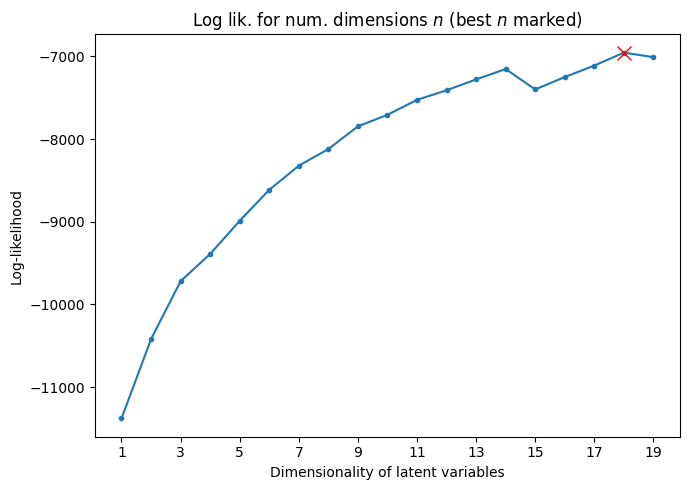

In [28]:
f = plt.figure(figsize=(7, 5))
plt.title('Log lik. for num. dimensions $n$ (best $n$ marked)')
plt.xlabel('Dimensionality of latent variables')
plt.ylabel('Log-likelihood')
plt.xticks(np.arange(1,20,2))
plt.plot(x_dims, log_likelihoods, '.-')
plt.plot(x_dims[np.argmax(log_likelihoods)], np.max(log_likelihoods), 'x', markersize=10, color='r')
plt.tight_layout()
plt.show()

In [54]:
gpfa_best_dim = GPFA(bin_size=20*pq.ms, x_dim=9)
gpfa_spike_train_trials = gpfa_best_dim.fit_transform(spiketrains=[trial for (trial,_) in spike_train_trials])

Initializing parameters using factor analysis...

Fitting GPFA model...


In [55]:
for i in range(N_trials): assert gpfa_spike_train_trials[0].shape[1]==100

In [56]:
trial_buckets = [buckets for (_,buckets) in spike_train_trials]

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

times_buckets = [
    times.loc[
            np.vectorize(lambda n: find_nearest(times.index.values, n))(buckets)
    ] for buckets in trial_buckets
]

speed_buckets = [
    times_bucket.groupby(times_bucket.index).first()['speed'] for times_bucket in times_buckets
]

In [57]:
traj_and_speed_data = {'trajectories':gpfa_spike_train_trials,'speeds':speed_buckets}
traj_and_speed_data

{'trajectories': array([array([[ 6.51617935e-01,  6.84199676e-01,  7.29926412e-01,
                 7.90797993e-01,  8.64083547e-01,  9.43918888e-01,
                 1.02566497e+00,  1.10488255e+00,  1.17824606e+00,
                 1.23274160e+00,  1.26997065e+00,  1.28329214e+00,
                 1.27450756e+00,  1.24181722e+00,  1.18662007e+00,
                 1.11638495e+00,  1.04302371e+00,  9.63899010e-01,
                 8.95043984e-01,  8.41287305e-01,  8.00306861e-01,
                 7.74234238e-01,  7.62408192e-01,  7.61051791e-01,
                 7.72366305e-01,  7.90452644e-01,  8.20256464e-01,
                 8.54926921e-01,  8.99433524e-01,  9.46461188e-01,
                 9.95330200e-01,  1.04120648e+00,  1.08018944e+00,
                 1.10859572e+00,  1.12417216e+00,  1.12635957e+00,
                 1.12060200e+00,  1.10989959e+00,  1.09569391e+00,
                 1.09049619e+00,  1.09660711e+00,  1.11643722e+00,
                 1.14629883e+00,  1.18748523e+

In [58]:
traj_and_speed_data['speeds'][0]

spike_time
1585.750325     1.376282
1585.770028     1.376282
1585.790288     1.041328
1585.809054     2.245632
1585.830128     1.154294
                 ...    
1587.649401    12.978217
1587.671678    11.947238
1587.689726    12.905869
1587.710127    15.156117
1587.729126    13.832394
Name: speed, Length: 100, dtype: float64

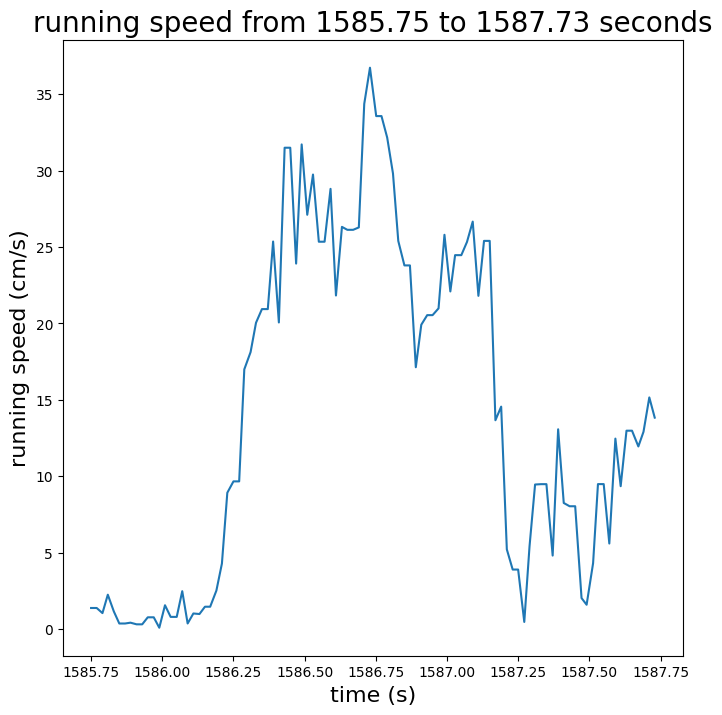

In [59]:
_=plot_running_speed(values=traj_and_speed_data['speeds'][0].values, timestamps=traj_and_speed_data['speeds'][0].index.values)
plt.savefig(f'./plots/speeds_{first_drifting_grating_presentation_id}.png')

In [60]:
import pickle as pkl

with open('../data/gpfa_spike_data.pkl','wb') as f:
    pkl.dump(gpfa_spike_train_trials,f)


In [61]:
with open('../data/traj_and_speed_data.pkl','wb') as f:
    pkl.dump(traj_and_speed_data,f)

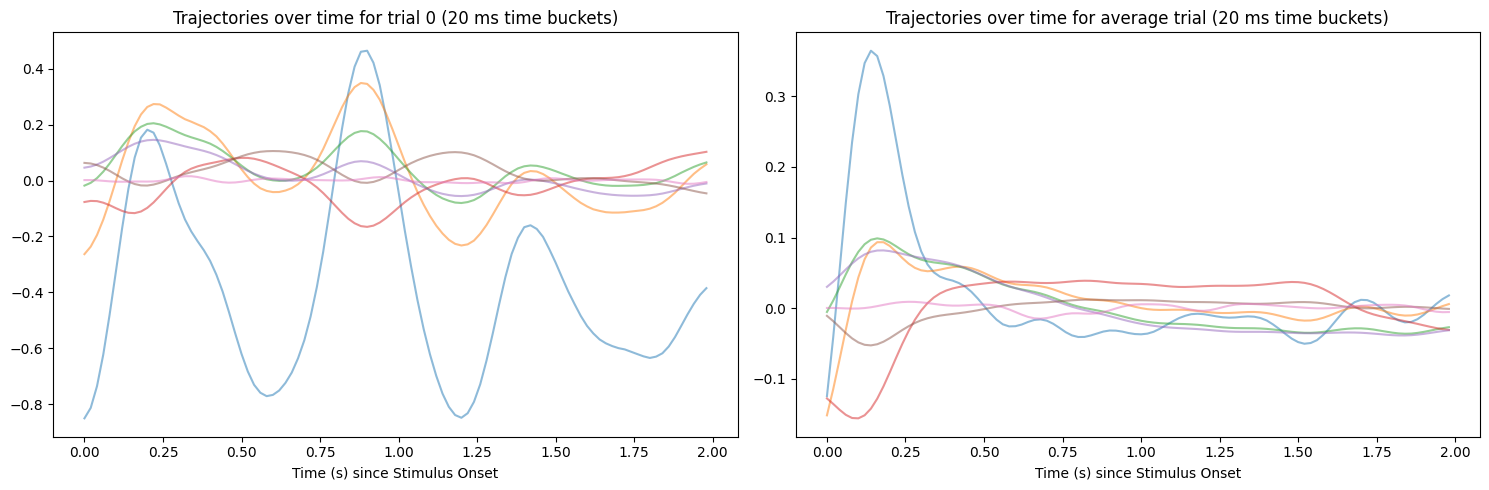

In [82]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15, 5))

for traj in gpfa_spike_train_trials[25]:
    ax1.plot(np.arange(0,2,0.02), traj, alpha=0.5)
ax1.set_title('Trajectories over time for trial 0 (20 ms time buckets)')
ax1.set_xlabel('Time (s) since Stimulus Onset')

for traj in gpfa_spike_train_trials.mean():
    ax2.plot(np.arange(0,2,0.02), traj, alpha=0.5)
ax2.set_title('Trajectories over time for average trial (20 ms time buckets)')
ax2.set_xlabel('Time (s) since Stimulus Onset')

plt.tight_layout()
plt.savefig('trajectories_extracted.png')

In [63]:
X = np.concatenate(traj_and_speed_data['trajectories'],axis=1).T
y = np.concatenate(traj_and_speed_data['speeds']).T

In [64]:
traj_and_speed_data['speeds']

[spike_time
 1585.750325     1.376282
 1585.770028     1.376282
 1585.790288     1.041328
 1585.809054     2.245632
 1585.830128     1.154294
                  ...    
 1587.649401    12.978217
 1587.671678    11.947238
 1587.689726    12.905869
 1587.710127    15.156117
 1587.729126    13.832394
 Name: speed, Length: 100, dtype: float64,
 spike_time
 1588.739305    14.781210
 1588.759360    19.407243
 1588.780293    18.304615
 1588.801360    17.374504
 1588.820705    17.374504
                  ...    
 1590.640236    12.385737
 1590.661127     9.359440
 1590.680194     8.190996
 1590.697794     8.190996
 1590.719461     4.965046
 Name: speed, Length: 100, dtype: float64,
 spike_time
 1591.740461    15.077551
 1591.759418     7.861351
 1591.779628    14.305027
 1591.799928    14.305027
 1591.820807    11.122946
                  ...    
 1593.640056    36.791790
 1593.656387    34.128834
 1593.680721    34.128834
 1593.699754    35.397864
 1593.719895    30.331706
 Name: speed, Length

In [65]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

pipeline_xgb = Pipeline([('scaler',MinMaxScaler()),('regressor',XGBRegressor())])
pipeline_xgb_params = pipeline_xgb.get_params().keys()

pipeline_rf = Pipeline([('scaler',MinMaxScaler()),('regressor',RandomForestRegressor())])
pipeline_rf_params = pipeline_rf.get_params().keys()

pipeline_ridge = Pipeline([('scaler',MinMaxScaler()),('regressor',Ridge())])
pipeline_ridge_params = pipeline_ridge.get_params().keys()

In [66]:
pipeline_ridge_params

dict_keys(['memory', 'steps', 'verbose', 'scaler', 'regressor', 'scaler__clip', 'scaler__copy', 'scaler__feature_range', 'regressor__alpha', 'regressor__copy_X', 'regressor__fit_intercept', 'regressor__max_iter', 'regressor__positive', 'regressor__random_state', 'regressor__solver', 'regressor__tol'])

In [67]:
hyperparameter_grid_xgb = {
    'regressor__n_estimators': [50, 100, 500, 1000, 2000],
    'regressor__max_depth': [3, 6, 9, 12, None],
    'regressor__learning_rate': [0.01, 0.03, 0.05, 0.1],
    'regressor__colsample_bytree': [0.2,0.4,0.6,0.8]
}

hyperparameter_grid_rf = {
    'regressor__n_estimators': [50, 100, 500, 1000, 2000],
    'regressor__max_depth': [3, 6, 9, 12, None]
}

hyperparameter_grid_ridge = {
    'regressor__alpha': [0,1,2,5,10,20],
    'regressor__fit_intercept': [True, False]
}


random_cv_xgb = RandomizedSearchCV(estimator=pipeline_xgb,
            param_distributions=hyperparameter_grid_xgb,
            cv=3,
            n_iter=3,
            scoring = 'r2',
            n_jobs = -1,
            verbose = 5, 
            return_train_score = True,
            random_state=42)

random_cv_rf = RandomizedSearchCV(estimator=pipeline_rf,
            param_distributions=hyperparameter_grid_rf,
            cv=3, 
            n_iter=3,
            scoring = 'r2',
            n_jobs = -1,
            verbose = 5, 
            return_train_score = True,
            random_state=42)

random_cv_ridge = RandomizedSearchCV(estimator=pipeline_ridge,
            param_distributions=hyperparameter_grid_ridge,
            cv=3, 
            n_iter=5,
            scoring = 'r2',
            n_jobs = -1,
            verbose = 5, 
            return_train_score = True,
            random_state=42)

In [68]:
random_cv_xgb.fit(X[:-100],y[:-100])
random_cv_rf.fit(X[:-100],y[:-100])
random_cv_ridge.fit(X[:-100],y[:-100])

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[CV 2/3] END regressor__colsample_bytree=0.6, regressor__learning_rate=0.05, regressor__max_depth=None, regressor__n_estimators=50;, score=(train=0.871, test=0.472) total time=   0.1s
[CV 1/3] END regressor__colsample_bytree=0.6, regressor__learning_rate=0.05, regressor__max_depth=None, regressor__n_estimators=50;, score=(train=0.868, test=0.419) total time=   0.1s
[CV 3/3] END regressor__colsample_bytree=0.6, regressor__learning_rate=0.05, regressor__max_depth=None, regressor__n_estimators=50;, score=(train=0.798, test=-2.618) total time=   0.1s
[CV 1/3] END regressor__colsample_bytree=0.4, regressor__learning_rate=0.01, regressor__max_depth=3, regressor__n_estimators=500;, score=(train=0.724, test=0.427) total time=   0.2s
[CV 3/3] END regressor__colsample_bytree=0.4, regressor__learning_rate=0.01, regressor__max_depth=3, regressor__n_estimators=500;, score=(train=0.672, test=-3.333) total time=   0.2s
[CV 2/3] END regressor__colsample_bytree=0.4, regressor__learning_rate=0.01, regre

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                             ('regressor', Ridge())]),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'regressor__alpha': [0, 1, 2, 5, 10,
                                                             20],
                                        'regressor__fit_intercept': [True,
                                                                     False]},
                   random_state=42, return_train_score=True, scoring='r2',
                   verbose=5)

In [69]:
best_pipe_xgb = random_cv_xgb.best_estimator_
best_pipe_xgb

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('regressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=0.8, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.03,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=1000, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [70]:
best_pipe_xgb.score(X[-100:],y[-100:])

-0.8097565243886509

In [71]:
best_pipe_rf = random_cv_rf.best_estimator_
best_pipe_rf

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('regressor', RandomForestRegressor(max_depth=12))])

In [72]:
pred = best_pipe_rf.predict(X[-100:])
np.sqrt(mean_squared_error(y[-100:],pred))

0.8136936387832746

In [73]:
best_pipe_ridge = random_cv_ridge.best_estimator_
best_pipe_ridge

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('regressor', Ridge(alpha=10, fit_intercept=False))])

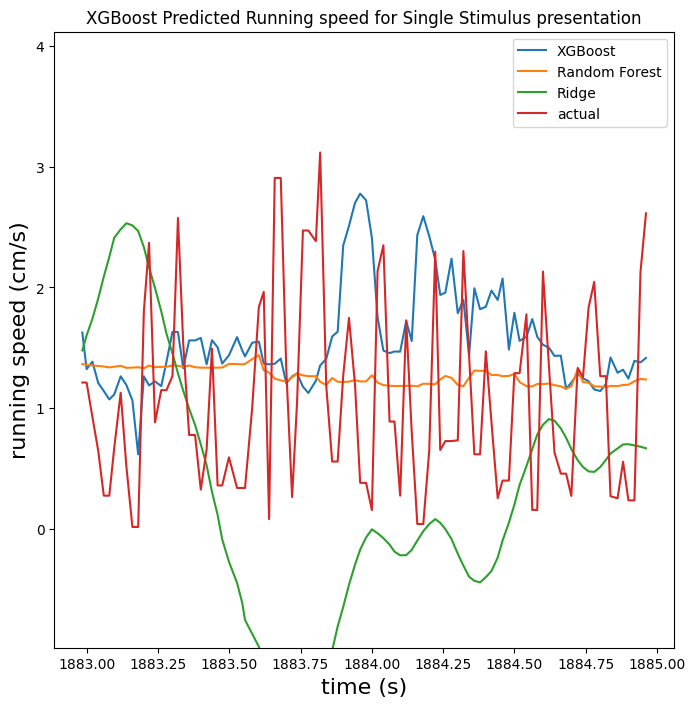

In [76]:
pred_xgb = best_pipe_xgb.predict(X[-100:])
pred_rf = best_pipe_rf.predict(X[-100:])
pred_ridge = best_pipe_ridge.predict(X[-100:])
_plot=plot_running_speed(values=pred_xgb, timestamps=traj_and_speed_data['speeds'][-1].index.values)
plt.plot(traj_and_speed_data['speeds'][-1].index.values,pred_rf)
plt.plot(traj_and_speed_data['speeds'][-1].index.values,pred_ridge)
plt.plot(traj_and_speed_data['speeds'][-1].index.values,traj_and_speed_data['speeds'][-1])
plt.ylim([traj_and_speed_data['speeds'][-1].min()-1,traj_and_speed_data['speeds'][-1].max()+1])
plt.legend(['XGBoost','Random Forest','Ridge', 'actual'])

plt.title('XGBoost Predicted Running speed for Single Stimulus presentation')
plt.savefig(f'./plots/speeds_predicted.png')

In [84]:
session.get_pupil_data()

,corneal_reflection_center_x,corneal_reflection_center_y,corneal_reflection_height,corneal_reflection_width,corneal_reflection_phi,pupil_center_x,pupil_center_y,pupil_height,pupil_width,pupil_phi,eye_center_x,eye_center_y,eye_height,eye_width,eye_phi
Time (s),,,,,,,,,,,,,,,
3.20620,321.221602,215.484021,11.091658,12.801322,-0.340513,291.258341,187.965473,96.294414,102.751684,-0.759200,310.242901,207.161069,273.535714,323.227726,0.099357
3.22948,321.291022,215.282122,11.318211,12.807982,-0.243113,290.703953,188.659872,94.239278,103.384550,-0.715791,310.140402,207.007975,273.303505,322.919143,0.091675
3.23714,321.294868,215.055000,11.136122,12.423237,-0.331511,290.687532,188.294754,94.729755,103.814759,-0.673967,310.224041,206.700513,273.481027,323.497356,0.090202
3.27028,321.288914,215.250999,10.596050,12.414694,-0.245863,289.154532,188.524943,93.877264,99.315115,-0.732209,310.134502,206.791105,273.988038,323.147754,0.091154
3.30396,320.819438,215.915143,9.366927,12.870596,0.109020,290.206682,187.411271,90.221821,103.856061,-0.583017,310.226498,206.519467,273.542559,322.233983,0.097546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9939.71240,322.580849,216.600349,12.799143,13.400555,-0.525985,NaN,NaN,NaN,NaN,NaN,313.501794,210.587410,280.224381,322.533004,0.167348
9939.74576,324.007748,216.520870,11.843170,13.212379,-0.403054,NaN,NaN,NaN,NaN,NaN,313.532165,211.023852,280.388767,322.942096,0.189335
9939.77918,324.118835,216.898871,11.336945,12.877454,-0.254458,NaN,NaN,NaN,NaN,NaN,314.227284,210.967838,279.978946,323.751767,0.201428
